In [1]:
import keras
keras.__version__

/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

In [19]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2

from keras import layers
from keras import models
from keras import optimizers
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

%matplotlib inline

In [3]:
base_dir = "data/chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

The structure of dataset is based on folders, which means classes are divided into different folders and each photo is in its associated class folder.

In [4]:
class_folders = glob(train_dir + '/*')
num_classes = len(class_folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 2


We have two class folders: NORMAL, PNEUMONIA

In [5]:
os.listdir(train_dir)

['NORMAL', 'PNEUMONIA']

# Defining the VGG 16 Model

In [6]:
IMAGE_SIZE = [128, 128] 

# Loading the weights of VGG16 without the top layer. 
# We are using Imagenet pre-reained weights
# input_shape = (128,128,3)
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x1 = Flatten()(vgg.output)

# we  add a new fully connected layer however it increase the execution time.
x2 = Dense(128, activation = 'relu')(x1) 

# adding the output layer with softmax function as this is a multi label classification problem.
x3 = Dense(num_classes, activation = 'sigmoid')(x2)  

model = Model(inputs = vgg.input, outputs = x3)

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
training_datagen = ImageDataGenerator(
                                    rescale=1./255,   # all pixel values will be between 0 an 1
                                    shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

In [10]:
# rescale=1./255,   # all pixel values will be between 0 an 1
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

#############################################################################################

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to 150x150
        target_size= IMAGE_SIZE,
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size= IMAGE_SIZE,
        batch_size=50,
        class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
# The labels are stored in class_indices in dictionary form. 
# checking the labels
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [12]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=100,
      verbose  = 2)

Epoch 1/30
 - 2023s - loss: 0.1591 - acc: 0.9389 - val_loss: 0.3366 - val_acc: 0.8125
Epoch 2/30
 - 1832s - loss: 0.1061 - acc: 0.9605 - val_loss: 0.1752 - val_acc: 0.9062
Epoch 3/30
 - 1850s - loss: 0.0931 - acc: 0.9660 - val_loss: 0.1884 - val_acc: 0.9688
Epoch 4/30
 - 2188s - loss: 0.0875 - acc: 0.9670 - val_loss: 0.1117 - val_acc: 0.9375
Epoch 5/30
 - 2188s - loss: 0.0819 - acc: 0.9700 - val_loss: 0.0763 - val_acc: 1.0000
Epoch 6/30
 - 2172s - loss: 0.0760 - acc: 0.9722 - val_loss: 0.0802 - val_acc: 1.0000
Epoch 7/30
 - 2804s - loss: 0.0749 - acc: 0.9716 - val_loss: 0.0902 - val_acc: 1.0000
Epoch 8/30
 - 2102s - loss: 0.0691 - acc: 0.9744 - val_loss: 0.2263 - val_acc: 0.8438
Epoch 9/30
 - 1640s - loss: 0.0673 - acc: 0.9754 - val_loss: 0.1146 - val_acc: 0.9688
Epoch 10/30
 - 1491s - loss: 0.0618 - acc: 0.9767 - val_loss: 0.1020 - val_acc: 1.0000
Epoch 11/30
 - 1490s - loss: 0.0633 - acc: 0.9763 - val_loss: 0.1317 - val_acc: 1.0000
Epoch 12/30
 - 1493s - loss: 0.0559 - acc: 0.9775 - 

In [13]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.18946018993854521
Test Accuracy:  0.84375


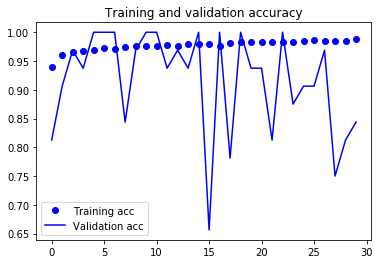

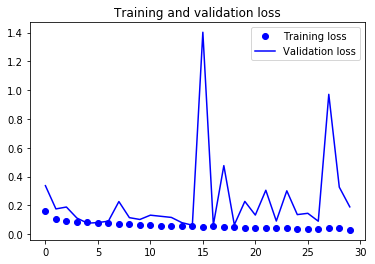

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

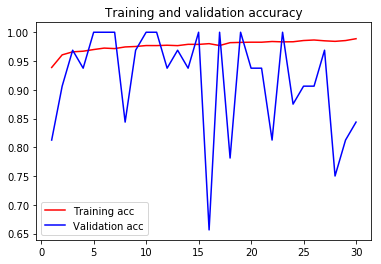

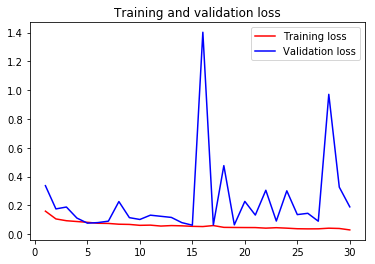

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

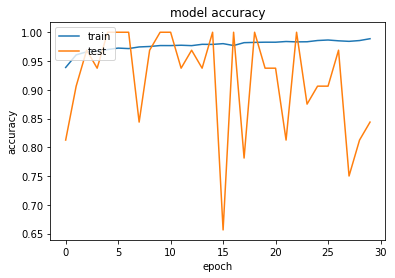

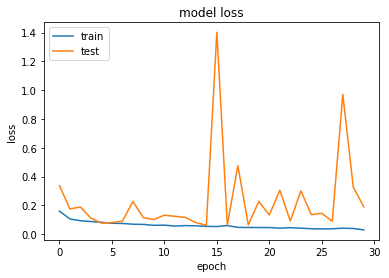

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()